<a href="https://colab.research.google.com/github/emilyzfliu/vis-sounds/blob/main/vis_sounds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import os
import pickle
from math import pi
import torch
import imageio
from torch.autograd import Variable
from torch.utils.data import Dataset
from tqdm import tqdm
import cv2


import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
from tqdm.notebook import tqdm
import os
import copy
import pandas as pd
import PIL 
from torch.utils.data import DataLoader
import random
  
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("WARNING: Could not find GPU! Using CPU only")
    print("You may want to try to use the GPU in Google Colab by clicking in:")
    print("Runtime > Change Runtime type > Hardware accelerator > GPU.")

Using the GPU!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip /content/drive/MyDrive/vis_sound_files/vis-data-simple.zip
!cp /content/drive/MyDrive/vis_sound_files/train.txt .
!cp /content/drive/MyDrive/vis_sound_files/test.txt .

Streaming output truncated to the last 5000 lines.
  inflating: vis-data-simple/2015-09-24-15-43-24-805/2015-09-24-15-43-24-805_spec_3.png  
  inflating: vis-data-simple/2015-09-24-15-43-24-805/2015-09-24-15-43-24-805_spec_37.png  
  inflating: vis-data-simple/2015-09-24-15-43-24-805/2015-09-24-15-43-24-805_spec_23.png  
  inflating: vis-data-simple/2015-09-24-15-43-24-805/2015-09-24-15-43-24-805_spec_27.png  
  inflating: vis-data-simple/2015-09-24-15-43-24-805/2015-09-24-15-43-24-805_spec_33.png  
  inflating: vis-data-simple/2015-09-24-15-43-24-805/2015-09-24-15-43-24-805_spec_7.png  
  inflating: vis-data-simple/2015-09-24-15-43-24-805/2015-09-24-15-43-24-805_labels_32.txt  
  inflating: vis-data-simple/2015-09-24-15-43-24-805/2015-09-24-15-43-24-805_labels_26.txt  
  inflating: vis-data-simple/2015-09-24-15-43-24-805/2015-09-24-15-43-24-805_labels_27.txt  
  inflating: vis-data-simple/2015-09-24-15-43-24-805/2015-09-24-15-43-24-805_labels_33.txt  
  inflating: vis-data-simple/2015

## Project Overview:

1. Predicting material from sound (spectrogram) only
2. Predicting material(s) from images only
3. Combined prediction

## Dataset
We use the Greatest Hits dataset at https://andrewowens.com/vis/.

In [ ]:
class VisSoundsDataset(Dataset):
  def __init__(self, split = 'train', mode='sound'):
    super(Dataset, self).__init__()
    assert split in ['train', 'val', 'test']
    self.split = split
    assert mode in ['sound', 'image', 'fc_agg', 'tt_agg']
    self.mode = mode

    if mode in ['image', 'fc_agg', 'tt_agg']:
      self.image_transforms = transforms.Compose([
          transforms.ToPILImage(),
          transforms.RandomHorizontalFlip(0.5),
          transforms.RandomVerticalFlip(0.5),
          transforms.ToTensor(),
        ])

    self.transforms = transforms.Compose([
          transforms.ToPILImage(),
          transforms.Resize((224, 224)),
          transforms.ToTensor(),
          transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        ])
    data = self.load_data()

    random.shuffle(data)

    if self.split == 'train':
      data = data[:int(0.8*len(data))]
      labels = data[:int(0.8*len(data))]
    elif self.split == 'val':
      data = data[int(0.8*len(data)):]
      labels = data[int(0.8*len(data)):]

    self.n = len(data)
    print(f'{self.n} datapoints')
    self.data = data

  def load_data(self):
    if self.split in ['train', 'val']:
      splits = 'train.txt'
    else:
      assert self.split == 'test'
      splits = 'test.txt'

    with open(splits, 'r') as f:
      files = f.readlines()
    
    data = []

    if self.mode == 'image':
      for file in files:
        file = file.strip()
        data.append(file)
    elif self.mode in ['sound', 'fc_agg']:
      for file in files:
        file = file.strip()  # remove line break
        with open(f'vis-data-simple/{file}/{file}_metadata.txt', 'r') as f:
          n_sounds = int(f.readline())
        for i in range(n_sounds):
          data.append((file, i))
    elif self.mode == 'tt_agg':
      # for every positive example, append 1 negative example as well
      class_dict = self.get_elements_in_classes(files)
      for file in files:
        file = file.strip()
        with open(f'vis-data-simple/{file}/{file}_metadata.txt', 'r') as f:
          n_sounds = int(f.readline())
        classes_in_file = self.gen_labels(file)
        for i in range(n_sounds):
          data.append((file, file, i, 1.0)) # positive example
          c = random.choice(torch.where(classes_in_file==0)[0].tolist())
          sound_spec, sound_id = random.choice(class_dict[c])
          data.append((file, sound_spec, sound_id, 0.0))
    #print(data)
    
    return data
  
  def get_elements_in_classes(self, files):
    classes = {}
    for file in files:
      file = file.strip()
      with open(f'vis-data-simple/{file}/{file}_metadata.txt', 'r') as f:
        n_sounds = int(f.readline())
      for i in range(n_sounds):
        class_id = self.gen_labels(file, i)
      if class_id not in classes:
        classes[class_id] = []
      classes[class_id].append((file, i))
    return classes
  
  def gen_labels(self, file, idx=None):
    if idx is None:
      ret = np.zeros((18,))
      with open(f'vis-data-simple/{file}/{file}_metadata.txt', 'r') as f:
        n_sounds = int(f.readline())
      for i in range(n_sounds):
        with open(f'vis-data-simple/{file}/{file}_labels_{i}.txt', 'r') as f:
          vals = f.readlines()
          mat_id = int(vals[0])
          ret[mat_id] = 1
      ret = torch.Tensor(ret)
    else:
      with open(f'vis-data-simple/{file}/{file}_labels_{idx}.txt', 'r') as f:
        vals = f.readlines()
        ret = int(vals[0])
    return ret
  
  def load_image_from_file(self, fname, image_tform = True):
    img = imageio.imread(fname, pilmode='RGB')
    if image_tform:
      img = self.image_transforms(img)
    img = self.transforms(img)
    return img

  def __getitem__(self, item):
    if self.mode == 'sound':
      vid_id, hit_id = self.data[item]
      img = self.load_image_from_file(f'vis-data-simple/{vid_id}/{vid_id}_spec_{hit_id}.png', image_tform = False)
      label = self.gen_labels(vid_id, hit_id)
      return img, label
    elif self.mode == 'image':
      vid_id = self.data[item]
      img = self.load_image_from_file(f'vis-data-simple/{vid_id}/{vid_id}_image.png', image_tform = True)
      label = self.gen_labels(vid_id)
      return img, label
    elif self.mode == 'fc_agg':
      vid_id, hit_id = self.data[item]
      sound = self.load_image_from_file(f'vis-data-simple/{vid_id}/{vid_id}_spec_{hit_id}.png', image_tform = False)
      img = self.load_image_from_file(f'vis-data-simple/{vid_id}/{vid_id}_image.png', image_tform = True)
      label = self.gen_labels(vid_id, hit_id)
      return torch.stack((sound, img), -1), label
    elif self.mode == 'tt_agg':
      img_id, sound_id, hit_id, label = self.data[item]
      img = self.load_image_from_file(f'vis-data-simple/{img_id}/{img_id}_image.png', image_tform = True)
      sound = self.load_image_from_file(f'vis-data-simple/{sound_id}/{sound_id}_spec_{hit_id}.png', image_tform = False)
      return torch.stack((sound, img), -1), label
    return None
  
  def get_class_data(self):
    assert self.mode != 'image', 'Not supported for multilabel (too lazy)'
    all_classifs = []
    for vid_id, hit_id in self.data:
      label = self.gen_labels(vid_id, hit_id)
      all_classifs.append(label)
    return all_classifs
      
  def __len__(self):
      return self.n

16205 datapoints


Text(0.5, 1.0, 'Class Distribution on Train Set (Material_ID)')

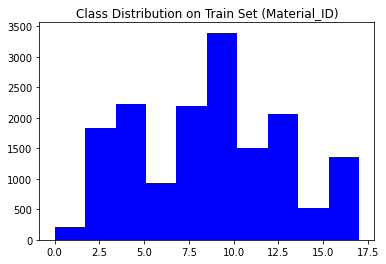

In [ ]:
data_stats_train = VisSoundsDataset(split = 'train', mode = 'sound')
all_classifs = data_stats_train.get_class_data()
plt.hist(all_classifs, color='blue')
plt.title('Class Distribution on Train Set (Material_ID)')

4052 datapoints


Text(0.5, 1.0, 'Class Distribution on Validation Set (Material_ID)')

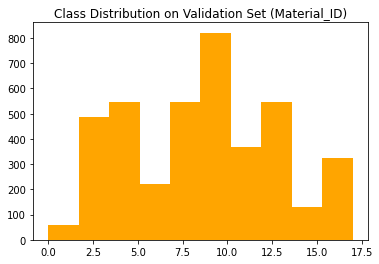

In [ ]:
data_stats_val = VisSoundsDataset(split = 'val', mode = 'sound')
all_classifs = data_stats_val.get_class_data()
plt.hist(all_classifs, color='orange')
plt.title('Class Distribution on Validation Set (Material_ID)')

6627 datapoints


Text(0.5, 1.0, 'Class Distribution on Test Set (Material_ID)')

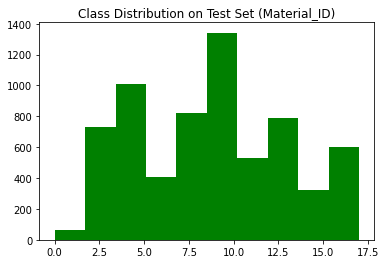

In [ ]:
data_stats_test = VisSoundsDataset(split = 'test', mode = 'sound')
all_classifs = data_stats_test.get_class_data()
plt.hist(all_classifs, color='green')
plt.title('Class Distribution on Test Set (Material_ID)')

# Training Setup

## Model Init

In [ ]:
def initialize_model(model_name, num_classes, resume_from = None, use_pretrained = False):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    # The model (nn.Module) to return
    model_ft = None
    # The input image is expected to be (input_size, input_size)
    input_size = 0
    
    # By default, all parameters will be trained (useful when you're starting from scratch)
    # Within this function you can set .requires_grad = False for various parameters, if you
    # don't want to learn them

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224
        
    elif model_name == "resnet50":
        """ Resnet50
        """
        model_ft = models.resnet50(pretrained=use_pretrained)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes) 
        input_size = 224

    else:
        raise Exception("Invalid model name!")
    
    if resume_from is not None:
        print("Loading weights from %s" % resume_from)
        model_ft.load_state_dict(torch.load(resume_from))
    
    return model_ft, input_size

## Dataloader Init

In [ ]:
from torchvision.transforms.functional import to_grayscale

def get_image_transforms(mode):
    # How to transform the image when you are loading them.
    # you'll likely want to mess with the transforms on the training set.
    
    # we convert the image to a [C,H,W] tensor, then normalize it to values with a given mean/stdev. These normalization constants
    # are derived from aggregating lots of data and happen to produce better results.
    transform = transforms.Compose([
            #transforms.Grayscale(num_output_channels=3),
            #transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    return transform

def get_dataloaders(input_size, batch_size, mode, shuffle = True):
    train_data = VisSoundsDataset(split = 'train', mode = mode)
    train_data = VisSoundsDataset(split = 'val', mode = mode)
    test_data = VisSoundsDataset(split = 'test', mode = mode)

    train_loader = DataLoader(train_data, batch_size = batch_size, shuffle = shuffle, num_workers = 4)
    val_loader = DataLoader(train_data, batch_size = batch_size, shuffle = False, num_workers = 4)
    test_loader = DataLoader(test_data, batch_size = batch_size, shuffle = False, num_workers = 4)
    loaders = {
        'train': train_loader,
        'val': val_loader,
        'test': test_loader
    }
    return loaders

## Model Train

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, save_dir = None, save_all_epochs=False, num_epochs=25, eval_mode='multiclass'):
    '''
    model: The NN to train
    dataloaders: A dictionary containing at least the keys 
                 'train','val' that maps to Pytorch data loaders for the dataset
    criterion: The Loss function
    optimizer: The algorithm to update weights 
               (Variations on gradient descent)
    num_epochs: How many epochs to train for
    save_dir: Where to save the best model weights that are found, 
              as they are found. Will save to save_dir/weights_best.pt
              Using None will not write anything to disk
    save_all_epochs: Whether to save weights for ALL epochs, not just the best
                     validation error epoch. Will save to save_dir/weights_e{#}.pt
    '''
    os.makedirs(save_dir, exist_ok=True)
    print(f'save dir is {save_dir}')
    since = time.time()

    val_acc_history = []
    train_acc_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            # TQDM has nice progress bars
            for inputs, labels in tqdm(dataloaders[phase]):

                if eval_mode == 'singleclass':
                  labels = labels.type(torch.FloatTensor)

                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    outputs = outputs.to(device)
                    loss = criterion(outputs, labels)

                    # torch.max outputs the maximum value, and its index
                    # Since the input is batched, we take the max along axis 1
                    # (the meaningful outputs)
                    if eval_mode == 'multiclass':
                      _, preds = torch.max(outputs, 1)
                    elif eval_mode == 'multilabel':
                      preds = torch.sigmoid(outputs > 0.5).long()
                    elif eval_mode == 'singleclass':
                      preds = torch.sigmoid(outputs > 0.5).long()

                    # backprop + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'train':
                train_acc_history.append(epoch_acc)
            if phase == 'val':
                val_acc_history.append(epoch_acc)
            if save_all_epochs:
                torch.save(model.state_dict(), os.path.join(save_dir, f'weights_{epoch}.pt'))

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # save and load best model weights
    torch.save(best_model_wts, os.path.join(save_dir, 'weights_best_val_acc.pt'))
    torch.save(model.state_dict(), os.path.join(save_dir, 'weights_last.pt'.format(epoch)))
    model.load_state_dict(best_model_wts)
    print('saved weights?')

    with open(os.path.join(save_dir, 'train_history.txt'), 'w') as f:
      for i in range(num_epochs):
        f.write(str(train_acc_history[i])+'\n')
    
    with open(os.path.join(save_dir, 'val_history.txt'), 'w') as f:
      for i in range(num_epochs):
        f.write(str(val_acc_history[i])+'\n')
    print('saved progress?')

    return model, val_acc_history, train_acc_history

## Training Params

In [ ]:
def make_optimizer(model, learning_rate, print_parameters=False):
    # Get all the parameters
    params_to_update = model.parameters()
    if print_parameters:
      print("Params to learn:")
      for name, param in model.named_parameters():
          if param.requires_grad == True:
              print("\t",name)

 
    optimizer = optim.SGD(params_to_update, lr=learning_rate, momentum=0.9)
    return optimizer

def get_loss(mode='multiclass'):
    if mode=='multilabel':
      criterion = nn.BCEWithLogitsLoss()
    # Create an instance of the loss function
    if mode == 'singleclass':
      criterion = nn.BCELoss()
    else:
      criterion = nn.CrossEntropyLoss()
    print(criterion)
    return criterion

In [52]:
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet]
# You can add your own, or modify these however you wish!
model_name = 'resnet'

# Number of classes in the dataset, normal, benign, malignant
num_classes = 18

# Batch size for training (change depending on how much memory you have)
batch_size = 32

# Shuffle the input data?
shuffle_datasets = True

# Number of epochs to train for 
num_epochs = 1

# Learning rate
learning_rate = 1e-3

### IO
# Path to a model file to use to start weights at
resume_from = None

# Whether to use a pretrained model, trained for classification in Imagenet-1k 
pretrained = False

# Save all epochs so that you can select the model from a particular epoch
save_all_epochs = False

# Whether to use early stopping (load the model with best accuracy), or not
early_stopping = True

# Directory to save weights to
save_dir = f'drive/MyDrive/vis_sound_files'
os.makedirs(save_dir, exist_ok=True)

# Actual Training

## Train Sound

In [54]:
model_1, input_size = initialize_model(model_name = model_name, num_classes = num_classes, resume_from=resume_from, use_pretrained=pretrained)

In [55]:

dataloaders = get_dataloaders(input_size, batch_size, 'sound', shuffle_datasets)
criterion = get_loss(mode='multiclass')

# Move the model to the gpu if needed
model_1 = model_1.to(device)

optimizer_1 = make_optimizer(model_1, learning_rate)

16205 datapoints
4052 datapoints
6627 datapoints
CrossEntropyLoss()


In [56]:
#Train the model!
trained_model_1, validation_history_1, train_history_1 = train_model(model=model_1, 
                                                                     dataloaders=dataloaders, 
                                                                     criterion=criterion, 
                                                                     optimizer=optimizer_1,
                                                                     save_dir=f'{save_dir}/trial_saving1', 
                                                                     save_all_epochs=save_all_epochs, 
                                                                     num_epochs=num_epochs)

del model_1, optimizer_1, trained_model_1

save dir is drive/MyDrive/vis_sound_files/trial_saving1
Epoch 1/1
----------


  0%|          | 0/127 [00:00<?, ?it/s]

train Loss: 2.6367 Acc: 0.1318


  0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 2.5109 Acc: 0.1819

Training complete in 0m 22s
Best val Acc: 0.181885
saved weights?
saved progress?


In [ ]:
!ls /content/vis-data-simple/2015-02-21-17-48-19

2015-02-21-17-48-19_image.png  2015-02-21-17-48-19_metadata.txt


In [ ]:
!ls content/drive/MyDrive/vis_sound_files

trial_saving


## Train Image

In [ ]:
model_1, input_size = initialize_model(model_name = model_name, num_classes = num_classes, resume_from=resume_from, use_pretrained=pretrained)

In [ ]:
dataloaders = get_dataloaders(input_size, batch_size, 'image', shuffle_datasets)
criterion = get_loss(mode='multilabel')

# Move the model to the gpu if needed
model_1 = model_1.to(device)

optimizer_1 = make_optimizer(model_1, learning_rate)

586 datapoints
147 datapoints
244 datapoints
BCEWithLogitsLoss()


In [ ]:
#Train the model!
trained_model_1, validation_history_1, train_history_1 = train_model(model=model_1, 
                                                                     dataloaders=dataloaders, 
                                                                     criterion=criterion, 
                                                                     optimizer=optimizer_1,
                                                                     save_dir=f'{save_dir}/image_models/{model_name}', 
                                                                     save_all_epochs=save_all_epochs, 
                                                                     num_epochs=num_epochs,
                                                                     eval_mode='multilabel')
del model_1, optimizer_1, trained_model_1

Epoch 1/1
----------


  0%|          | 0/5 [00:00<?, ?it/s]

train Loss: 0.8375 Acc: 16.0068


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.7218 Acc: 16.0068

Training complete in 0m 3s
Best val Acc: 16.006803


## Train Sound + Image FC_AGG

In [ ]:
class FCAggregator(nn.Module):
  def __init__(self, model_name, num_classes, resume_from = None, use_pretrained=False):
    super(FCAggregator, self).__init__()
    self.conv_image, _ = initialize_model(model_name = model_name, num_classes = 128,\
                                          resume_from=resume_from, use_pretrained=pretrained)
    self.conv_sound, _ = initialize_model(model_name = model_name, num_classes = 128,\
                                          resume_from=resume_from, use_pretrained=pretrained)
    self.fclayer = torch.nn.Linear(256, num_classes)
  def forward(self, x):
    sound = x[:,:,:,:,0]
    image = x[:,:,:,:,1]
    z_sound = self.conv_sound(sound)
    z_image = self.conv_image(image)
    z = torch.cat((z_sound, z_image), dim=1)
    z = nn.ReLU()(z)
    return self.fclayer(z)

In [ ]:
model_1 = FCAggregator(model_name = model_name, num_classes = num_classes, resume_from=resume_from, use_pretrained=pretrained)
input_size = 224

In [ ]:
dataloaders = get_dataloaders(input_size, batch_size, 'fc_agg', shuffle_datasets)
criterion = get_loss(mode='multiclass')

# Move the model to the gpu if needed
model_1 = model_1.to(device)

optimizer_1 = make_optimizer(model_1, learning_rate)

16205 datapoints
4052 datapoints
6627 datapoints
CrossEntropyLoss()


In [ ]:
#Train the model!
trained_model_1, validation_history_1, train_history_1 = train_model(model=model_1, 
                                                                     dataloaders=dataloaders, 
                                                                     criterion=criterion, 
                                                                     optimizer=optimizer_1,
                                                                     save_dir=f'{save_dir}/fc_agg_models/{model_name}', 
                                                                     save_all_epochs=save_all_epochs, 
                                                                     num_epochs=num_epochs,
                                                                     eval_mode='multiclass')
del model_1, optimizer_1, trained_model_1

Epoch 1/1
----------


  0%|          | 0/127 [00:00<?, ?it/s]

train Loss: 2.4762 Acc: 0.2221


  0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 2.2945 Acc: 0.2712

Training complete in 1m 20s
Best val Acc: 0.271224


## Train Sound + Image TT_AGG

In [ ]:
class TTAggregator(nn.Module):
  def __init__(self, model_name, num_classes, resume_from = None, use_pretrained=False):
    super(TTAggregator, self).__init__()
    self.conv_image, _ = initialize_model(model_name = model_name, num_classes = 128,\
                                          resume_from=resume_from, use_pretrained=pretrained)
    self.conv_sound, _ = initialize_model(model_name = model_name, num_classes = 128,\
                                          resume_from=resume_from, use_pretrained=pretrained)
    self.cos = nn.CosineSimilarity(dim=1)
  def forward(self, x):
    sound = x[:,:,:,:,0]
    image = x[:,:,:,:,1]
    z_sound = self.conv_sound(sound)
    z_image = self.conv_image(image)
    return self.cos(z_image, z_sound)/2 + 0.5

In [ ]:
model_1 = TTAggregator(model_name = model_name, num_classes = num_classes, resume_from=resume_from, use_pretrained=pretrained)
input_size = 224

In [ ]:
dataloaders = get_dataloaders(input_size, batch_size, 'tt_agg', shuffle_datasets)
criterion = get_loss(mode='singleclass')

# Move the model to the gpu if needed
model_1 = model_1.to(device)

optimizer_1 = make_optimizer(model_1, learning_rate)

32411 datapoints
8103 datapoints
13254 datapoints
BCELoss()


In [ ]:
#Train the model!
trained_model_1, validation_history_1, train_history_1 = train_model(model=model_1, 
                                                                     dataloaders=dataloaders, 
                                                                     criterion=criterion, 
                                                                     optimizer=optimizer_1,
                                                                     save_dir=f'{save_dir}/tt_agg_models/{model_name}', 
                                                                     save_all_epochs=save_all_epochs, 
                                                                     num_epochs=num_epochs,
                                                                     eval_mode='singleclass')
del model_1, optimizer_1, trained_model_1

Epoch 1/1
----------


  0%|          | 0/254 [00:00<?, ?it/s]

train Loss: 0.6891 Acc: 0.5020


  0%|          | 0/254 [00:00<?, ?it/s]

val Loss: 0.6826 Acc: 0.5020

Training complete in 2m 40s
Best val Acc: 0.502036


# Evaluations

In [ ]:
# Load your final model, that we will use for the rest of the PSET.
if early_stopping:
  weights_file = save_dir + '/weights_best_val_acc.pt'
else:
  weights_file = save_dir + '/weights_last.pt'
model_yours, _ = initialize_model(model_name = model_name, num_classes = num_classes, resume_from=resume_from, use_pretrained=pretrained)

# Move the model to the gpu if needed
model_yours = model_yours.to(device)

# Load weights for model_yours
model_yours.load_state_dict(torch.load(weights_file))

# set models to eval mode
model_yours = model_yours.eval()



In [ ]:
def evaluate(model, dataloader, criterion, is_labelled = False, generate_labels = True, k = 5):
    # If is_labelled, we want to compute loss, top-1 accuracy and top-5 accuracy
    # If generate_labels, we want to output the actual labels
    # Set the model to evaluate mode
    model.eval()
    running_loss = 0
    running_top1_correct = 0
    running_top5_correct = 0
    predicted_labels = []
    gt_labels = []

    # Iterate over data.
    # TQDM has nice progress bars
    for inputs, labels in tqdm(dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        tiled_labels = torch.stack([labels.data for i in range(k)], dim=1) 
        # Makes this to calculate "top 5 prediction is correct"
        # [[label1 label1 label1 label1 label1], [label2 label2 label2 label label2]]

        # forward
        # track history if only in train
        with torch.set_grad_enabled(False):
            # Get model outputs and calculate loss
            outputs = model(inputs)
            if is_labelled:
                loss = criterion(outputs, labels)

            # torch.topk outputs the maximum values, and their indices
            # Since the input is batched, we take the max along axis 1
            # (the meaningful outputs)
            _, preds = torch.topk(outputs, k=k, dim=1)
            if generate_labels:
                # We want to store these results
                nparr = preds.cpu().detach().numpy()
                predicted_labels.extend([list(nparr[i]) for i in range(len(nparr))])
                gt_labels.extend(np.array(labels.cpu()))

        if is_labelled:
            # statistics
            running_loss += loss.item() * inputs.size(0)
            # Check only the first prediction
            running_top1_correct += torch.sum(preds[:, 0] == labels.data)
            # Check all 5 predictions
            running_top5_correct += torch.sum(preds == tiled_labels)
        else:
            pass

    # Only compute loss & accuracy if we have the labels
    if is_labelled:
        epoch_loss = float(running_loss / len(dataloader.dataset))
        epoch_top1_acc = float(running_top1_correct.double() / len(dataloader.dataset))
        epoch_top5_acc = float(running_top5_correct.double() / len(dataloader.dataset))
    else:
        epoch_loss = None
        epoch_top1_acc = None
        epoch_top5_acc = None
    
    # Return everything
    return epoch_loss, epoch_top1_acc, gt_labels, predicted_labels  

In [ ]:
# Get data on the validation set
# Setting this to false will be a little bit faster
generate_validation_labels = True
val_loss_yours, val_top1_yours, _, val_labels_yours = evaluate(model_yours, dataloaders['val'], criterion, is_labelled = True, generate_labels = generate_validation_labels, k = 1)
# Get predictions for the test set
test_loss_yours, test_top1_yours, _, test_labels_yours = evaluate(model_yours, dataloaders['test'], criterion, is_labelled = True, generate_labels = generate_validation_labels, k = 1)

print("Your Trained model: ")
print("Val Top-1 Accuracy: {}".format(val_top1_yours))
print("Test Top-1 Accuracy: {}".format(test_top1_yours))